#### Average classifiers performances over *k* different train/test splits
Reproduce `3_classes_task_original.ipynb` & `3_classes_task_transformed.ipynb` notebooks, with k different train/test splits.

In [1]:
import pandas as pd
import os
import random 
import numpy as np
from collections import Counter
import torch
from classification_utils import fill_NaN, compute_Scattering1D
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from classification_utils import get_logistic_model, train_logistic_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2)
random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

Paths

In [2]:
ssc_path = 'labelled_data/SSC/'
si_path = 'labelled_data/SI/'
non_event_path = 'labelled_data/before_event/'
multiclass_sample = 'labelled_data/sample_for_multiclass_w_SMOTE.txt'

Scattering parametes

In [3]:
# scattering params
T = 20*60 + 1 
J = 10
Q = 5 
log_eps = 1e-6

Utility functions to perform k-folds models 

In [4]:
def perform_logistic_regression(seed, Sx_train, y_train_resampled):
    # define logistic regression model
    num_input = Sx_train.shape[-1]
    num_classes = y_train_resampled.unique().numel()
    model, opt, criterion = get_logistic_model(num_input, num_classes)

    # train model 
    num_epochs, n_samples, batch_size = 10, Sx_train.shape[0], 32
    train_logistic_model(Sx_train, y_train_resampled, model, opt, 
                            criterion, num_epochs, n_samples, batch_size,
                            verbose=False)
    model.eval()

    return model

In [5]:
def perform_random_forest(seed, Sx_train, y_train_resampled, 
                          param_grid=False,
                          n_splits=10, n_repeats=5):
    '''k-folds CV Random Forest'''
    rf_classifier = RandomForestClassifier(random_state=seed)

    if param_grid==False:
        param_grid = {
            'n_estimators': [50, 100, 150],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

    # 10 folds CV
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

    # grid search with 10-fold cross-validation
    grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            n_jobs=-1,
                            cv=cv)
    grid_search_rf.fit(Sx_train.numpy(), y_train_resampled.numpy()) 

    rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=seed).fit(Sx_train.numpy(), y_train_resampled.numpy())

    return rf

In [6]:
def perform_svc(seed, Sx_train, y_train_resampled, 
                param_grid=False,
                n_splits=10, n_repeats=5):
    '''k-folds CV SVC'''
    if param_grid==False:
        param_grid = { 
                'C': [ 0.1,  1. , 2., 10. ], # regularization
                'class_weight':[{0:1, 1:2.2, 2:1},
                                {0:1, # class : weight
                                1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                                2:1},  
                                {0:1, 1:1.5, 2:1.2},
                                {0:1, 1:2, 2:1.5}
                                ],
                'kernel': ['poly', 'rbf', 'sigmoid'],
                'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
                }


    # 10 folds CV
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    grid_search = GridSearchCV(estimator=SVC(), 
                                param_grid=param_grid, 
                                scoring='accuracy', 
                                refit='accuracy', 
                                n_jobs=-1, 
                                cv=cv)
    gridCV = grid_search.fit(Sx_train, y_train_resampled)
    # gridCV.best_params_

    svc = SVC(**gridCV.best_params_, random_state=seed, probability=True).fit(Sx_train, y_train_resampled)

    return svc

Get data

In [7]:
if os.path.exists(multiclass_sample):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(multiclass_sample, 'r') as file:
        for line in file:
            all_seq_data_files.append(line.strip())
    print( Counter([all_seq_data_files[i].split('/')[1] for i in range(len(all_seq_data_files))]) )

    si_files, ssc_files, random_non_ev_files = [], [], []
    for path in all_seq_data_files:
        if path.split('/')[1] == 'SI':
            si_files.append(path)
        elif path.split('/')[1] == 'SSC':
            ssc_files.append(path)
        elif path.split('/')[1] == 'before_event':
            random_non_ev_files.append(path)
        else:
            raise ValueError('File not belonging to any class!')
else:

    # get all data files paths
    # use all SI and all SSC, and a sample of non-events 
    si_files = [si_path + item for item in os.listdir(si_path)] 
    ssc_files = [ssc_path + item for item in os.listdir(ssc_path)] 
    non_ev_files = [non_event_path + item for item in os.listdir(non_event_path)]

    print('SI: {}, SSC: {}'.format(len(si_files), len(ssc_files)))

    # number of non-event to random sample (take as many non-events as the majority class between SSC & SI)
    sample_non_ev = np.max([len(si_files), len(ssc_files)])
    print('Non-events: {}'.format(sample_non_ev))

    # SAMPLE NON-EVENT
    random_non_ev_files = random.sample(non_ev_files, sample_non_ev)
    all_seq_data_files = si_files + ssc_files + random_non_ev_files

    # save sampled used to use always the same in the following trials
    with open(multiclass_sample, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

Counter({'SSC': 120, 'before_event': 120, 'SI': 73})


In [8]:
# initialize 2D tensors (each row is a different sequence)

seq_si = torch.zeros(len(si_files), T, dtype=torch.float32)
seq_ssc = torch.zeros(len(ssc_files), T, dtype=torch.float32)
seq_ne = torch.zeros(len(random_non_ev_files), T, dtype=torch.float32)

lab_dict = {'SSC':seq_ssc, 'SI':seq_si, 'before_event':seq_ne} # which tensor to update based on class

filling_method = 'linear_interpolation' 

indx_to_update = {'SSC':0, 'SI':0, 'before_event':0} # index of seq to update in each tensor 
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get right tensor to fill
    sequences_class_x = lab_dict[e.split('/')[1]]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # compute columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2

    # add data to sequences tensor
    i = indx_to_update[e.split('/')[1]]
    sequences_class_x[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update counter (next row)
    indx_to_update[e.split('/')[1]] += 1

In [9]:
len(seq_ne), len(seq_si), len(seq_ssc)

(120, 73, 120)

In [10]:
# concat tensors and labels
all_seqs = torch.cat([seq_si, seq_ssc, seq_ne], dim=0).numpy()  
ys = len(seq_si)*['SI'] + len(seq_ssc)*['SSC'] + len(seq_ne)*['non-event']

# to tensor
seqs = torch.from_numpy(all_seqs)

# labels to tensor + map classes to int
# replace str with int code
lab_to_int = {'non-event': 0, 'SI': 1, 'SSC': 2}
y = list(map(lambda x: lab_to_int[x], ys))
# to tensor
y = torch.tensor(y)

Get performances over k different train-test splits

In [11]:
def k_train_test_splits(k=10, 
                        perform_model='SVC', n_splits=10, n_repeats=5, param_grid=False,
                        scattering_net=True, 
                        verbose=False):
    # generate k different random integers for seeds (to have k different splits)
    seeds = random.sample(range(1, k * 10), k)

    k_splits_metrics = {} # store performances per split

    for seed in seeds:
        # split train and test set
        X_train, X_test, y_train, y_test = train_test_split(seqs, y, test_size=0.3, shuffle=True, random_state=seed)

        if verbose:
            print('Sizes seqs, X_train, X_test:')
            print(np.shape(seqs), np.shape(X_train), np.shape(X_test))

        # ----------------------------------------------

        # SMOTE
        smote = SMOTE(k_neighbors=20, random_state=seed)
        # smote = SVMSMOTE(k_neighbors=5, random_state=seed)
        X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train, y_train)

        # to tensor
        X_train_resampled, y_train_resampled = torch.tensor(X_train_resampled_np), torch.tensor(y_train_resampled_np)

        # shuffle so that synthetic sequences are not all the end
        X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=seed)

        # ----------------------------------------------

        # DECIDE WHETHER TO USE ORIGINAL SEQUENCES OR WAVELETS SCATTERING NETWORK FEATURES
        if scattering_net:
            Sc_all_train = compute_Scattering1D(X_train_resampled, T, J, Q, log_eps)
            Sc_all_test = compute_Scattering1D(X_test, T, J, Q, log_eps)

            # np.isnan(Sc_all_train).any(), np.isnan(Sc_all_test).any()
            if np.isnan(Sc_all_train).any():
                warnings.warn("Warning: Train array contains NaN values; seed:", seed)
            if np.isnan(Sc_all_test).any():
                warnings.warn("Warning: Test array contains NaN values; seed:", seed)

            mu_train = Sc_all_train.mean(dim=0)
            std_train = Sc_all_train.std(dim=0)

            Sx_train = (Sc_all_train - mu_train) / std_train
            Sx_test = (Sc_all_test - mu_train) / std_train

        else:
            mu_train = X_train_resampled.mean(dim=0)
            std_train = X_train_resampled.std(dim=0)

            Sx_train = (X_train_resampled - mu_train) / std_train
            Sx_test = (X_test - mu_train) / std_train

        # ----------------------------------------------
        
        if perform_model == 'SVC':
            model = perform_svc(seed, Sx_train, y_train_resampled, 
                                    param_grid=param_grid,
                                    n_splits=n_splits, n_repeats=n_repeats)
            preds = model.predict(Sx_test)
            
        elif perform_model == 'random_forest':
            model = perform_random_forest(seed, Sx_train, y_train_resampled, 
                          param_grid=param_grid,
                          n_splits=n_splits, n_repeats=n_repeats)
            preds = model.predict(Sx_test)
        
        elif perform_model == 'log_reg':
            model = perform_logistic_regression(seed, Sx_train, y_train_resampled)
            resp = model.forward(Sx_test)
            preds = resp.argmax(dim=1).numpy()
            
        else:
            raise ValueError('Model not implemented')
        
        
        confusion = confusion_matrix(y_test, preds)

        # probabilities class assignment
        # probs = model.predict_proba(Sx_test)

        # performance metrics
        acc = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average='weighted')
        recall = recall_score(y_test, preds, average='weighted')
        f1 = f1_score(y_test, preds, average='weighted')
        # metrics per class
        precision_per_class, recall_per_class, f1_score_per_class, support_per_class = precision_recall_fscore_support(y_test, preds)

        k_splits_metrics[seed] = {
                                  'confusion_matrix':confusion,
                                  'accuracy':acc,
                                  'precision':precision,
                                  'recall':recall,
                                  'F1':f1,
                                  'precision_per_class':precision_per_class, 
                                  'recall_per_class':recall_per_class, 
                                  'f1_score_per_class':f1_score_per_class
                                  }
    return k_splits_metrics

In [12]:
transformed_rf = k_train_test_splits(k=10, 
                                    perform_model='random_forest',
                                    scattering_net=True)

In [13]:
transformed_svc = k_train_test_splits(k=10, 
                                    perform_model='SVC',
                                    scattering_net=True)

In [14]:
transformed_log_reg = k_train_test_splits(k=10, 
                                    perform_model='log_reg',
                                    scattering_net=True)

In [15]:
transformed_rf

{8: {'confusion_matrix': array([[24,  6,  2],
         [ 1, 13,  8],
         [ 4,  7, 29]]),
  'accuracy': 0.7021276595744681,
  'precision': 0.7151739187689298,
  'recall': 0.7021276595744681,
  'F1': 0.7070647142884475,
  'precision_per_class': array([0.82758621, 0.5       , 0.74358974]),
  'recall_per_class': array([0.75      , 0.59090909, 0.725     ]),
  'f1_score_per_class': array([0.78688525, 0.54166667, 0.73417722])},
 12: {'confusion_matrix': array([[36,  6,  1],
         [ 0, 14,  9],
         [ 1,  9, 18]]),
  'accuracy': 0.723404255319149,
  'precision': 0.7546945331244671,
  'recall': 0.723404255319149,
  'F1': 0.7349427168576105,
  'precision_per_class': array([0.97297297, 0.48275862, 0.64285714]),
  'recall_per_class': array([0.8372093 , 0.60869565, 0.64285714]),
  'f1_score_per_class': array([0.9       , 0.53846154, 0.64285714])},
 11: {'confusion_matrix': array([[34,  4,  1],
         [ 2, 17,  4],
         [ 0, 14, 18]]),
  'accuracy': 0.7340425531914894,
  'precision

In [16]:
transformed_svc

{28: {'confusion_matrix': array([[34,  4,  0],
         [ 3, 12,  5],
         [ 3, 10, 23]]),
  'accuracy': 0.7340425531914894,
  'precision': 0.7564063595978489,
  'recall': 0.7340425531914894,
  'F1': 0.7387019972010721,
  'precision_per_class': array([0.85      , 0.46153846, 0.82142857]),
  'recall_per_class': array([0.89473684, 0.6       , 0.63888889]),
  'f1_score_per_class': array([0.87179487, 0.52173913, 0.71875   ])},
 78: {'confusion_matrix': array([[32, 10,  0],
         [ 3, 20,  3],
         [ 0,  2, 24]]),
  'accuracy': 0.8085106382978723,
  'precision': 0.8272458628841607,
  'recall': 0.8085106382978723,
  'F1': 0.8126308000337266,
  'precision_per_class': array([0.91428571, 0.625     , 0.88888889]),
  'recall_per_class': array([0.76190476, 0.76923077, 0.92307692]),
  'f1_score_per_class': array([0.83116883, 0.68965517, 0.90566038])},
 5: {'confusion_matrix': array([[29,  8,  0],
         [ 4, 15,  4],
         [ 2,  9, 23]]),
  'accuracy': 0.7127659574468085,
  'precisi

In [17]:
transformed_log_reg

{66: {'confusion_matrix': array([[33,  3,  0],
         [ 6,  8, 12],
         [ 2,  2, 28]]),
  'accuracy': 0.7340425531914894,
  'precision': 0.7167618059159315,
  'recall': 0.7340425531914894,
  'F1': 0.7065180682201958,
  'precision_per_class': array([0.80487805, 0.61538462, 0.7       ]),
  'recall_per_class': array([0.91666667, 0.30769231, 0.875     ]),
  'f1_score_per_class': array([0.85714286, 0.41025641, 0.77777778])},
 48: {'confusion_matrix': array([[31,  1,  5],
         [ 1,  3, 11],
         [ 6,  6, 30]]),
  'accuracy': 0.6808510638297872,
  'precision': 0.6603778178100199,
  'recall': 0.6808510638297872,
  'F1': 0.6683301096067054,
  'precision_per_class': array([0.81578947, 0.3       , 0.65217391]),
  'recall_per_class': array([0.83783784, 0.2       , 0.71428571]),
  'f1_score_per_class': array([0.82666667, 0.24      , 0.68181818])},
 70: {'confusion_matrix': array([[26,  2,  5],
         [ 3,  9, 15],
         [ 3,  3, 28]]),
  'accuracy': 0.6702127659574468,
  'precis

Average performances over k train/test splits

Overall performances

In [18]:
avg_acc_log_reg = np.mean([transformed_log_reg[k]['accuracy'] for k in transformed_log_reg])
avg_prec_log_reg = np.mean([transformed_log_reg[k]['precision'] for k in transformed_log_reg])
avg_recall_log_reg = np.mean([transformed_log_reg[k]['recall'] for k in transformed_log_reg])
avg_f1_log_reg = np.mean([transformed_log_reg[k]['F1'] for k in transformed_log_reg])

In [19]:
def metrics_summary_per_model(dict_performances):
    return np.mean([dict_performances[k]['accuracy'] for k in dict_performances]),\
            np.mean([dict_performances[k]['precision'] for k in dict_performances]),\
            np.mean([dict_performances[k]['recall'] for k in dict_performances]),\
            np.mean([dict_performances[k]['F1'] for k in dict_performances])

In [20]:
result_report = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic Regression': metrics_summary_per_model(transformed_log_reg),
    'SVC': metrics_summary_per_model(transformed_svc),
    'Random Forest': metrics_summary_per_model(transformed_rf)
    }

result_report_df = pd.DataFrame(result_report)

result_report_df.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True), axis=1)

,Metric,Logistic Regression,SVC,Random Forest
0,Accuracy,0.679787,0.738298,0.721277
1,Precision,0.666612,0.769223,0.740115
2,Recall,0.679787,0.738298,0.721277
3,F1-Score,0.659956,0.744979,0.726628


Performances per class

In [21]:
log_reg_class_precision_matrix = np.array([transformed_log_reg[k]['precision_per_class'] for k in transformed_log_reg])
log_reg_class_precision_matrix

array([[0.80487805, 0.61538462, 0.7       ],
       [0.81578947, 0.3       , 0.65217391],
       [0.8125    , 0.64285714, 0.58333333],
       [0.775     , 0.41666667, 0.69047619],
       [0.79487179, 0.53846154, 0.57142857],
       [0.85714286, 0.44444444, 0.70731707],
       [0.79487179, 0.625     , 0.66666667],
       [0.9       , 0.55555556, 0.58181818],
       [0.76315789, 0.47368421, 0.51351351],
       [0.75609756, 0.33333333, 0.61363636]])

In [22]:
avg_prec_class0_log_reg = np.mean(log_reg_class_precision_matrix[:,0])
avg_prec_class1_log_reg = np.mean(log_reg_class_precision_matrix[:,1])
avg_prec_class2_log_reg = np.mean(log_reg_class_precision_matrix[:,2])
avg_prec_class0_log_reg, avg_prec_class1_log_reg, avg_prec_class2_log_reg

(0.8074309425063596, 0.4945387507229612, 0.628036380708703)

In [23]:
def get_avg_metric_per_class(dict_results, metric='precision_per_class'):
    perf_matrix = np.array([dict_results[k][metric] for k in dict_results])
    avg_metric_class0 = np.mean(perf_matrix[:,0])
    avg_metric_class1 = np.mean(perf_matrix[:,1])
    avg_metric_class2 = np.mean(perf_matrix[:,2])
    return avg_metric_class0, avg_metric_class1, avg_metric_class2


In [24]:
result_report = {
    'Model': ['┌', 'Logistic Regression', '∟', '┌', 'SVC', '∟', '┌', 'Random Forest', '∟' ],
    'Class': ['Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)',  'Non-Event (0)', 'SI (1)', 'SSC (2)'],
    'Precision': np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='precision_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='precision_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='precision_per_class')]),

    'Recall':np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='recall_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='recall_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='recall_per_class')]),

    'F1-Score':np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='f1_score_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='f1_score_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='f1_score_per_class')])
 }

result_report_df = pd.DataFrame(result_report)

result_report_df.set_index('Model')

,Class,Precision,Recall,F1-Score
Model,,,,
┌,Non-Event (0),0.807431,0.844843,0.824057
Logistic Regression,SI (1),0.494539,0.281101,0.354041
∟,SSC (2),0.628036,0.776998,0.692589
┌,Non-Event (0),0.869363,0.835715,0.850180
SVC,SI (1),0.500690,0.671675,0.568598
∟,SSC (2),0.825938,0.685770,0.745112
┌,Non-Event (0),0.895399,0.807965,0.848506
Random Forest,SI (1),0.499735,0.593714,0.540313
∟,SSC (2),0.722849,0.707533,0.711533


In [25]:
result_report_df.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True), axis=0)

,Model,Class,Precision,Recall,F1-Score
0,┌,Non-Event (0),0.807431,0.844843,0.824057
1,Logistic Regression,SI (1),0.494539,0.281101,0.354041
2,∟,SSC (2),0.628036,0.776998,0.692589
3,┌,Non-Event (0),0.869363,0.835715,0.850180
4,SVC,SI (1),0.500690,0.671675,0.568598
5,∟,SSC (2),0.825938,0.685770,0.745112
6,┌,Non-Event (0),0.895399,0.807965,0.848506
7,Random Forest,SI (1),0.499735,0.593714,0.540313
8,∟,SSC (2),0.722849,0.707533,0.711533


In [26]:
pd.DataFrame({
    'Model': ['Log Reg Non-Event (0)', 'Log Reg SI (1)', 'Log Reg SSC (2)', 
              'SVC Non-Event (0)', 'SVC SI (1)', 'SVC SSC (2)', 
              'RF Non-Event (0)', 'RF SI (1)', 'RF SSC (2)'],

    'Precision': np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='precision_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='precision_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='precision_per_class')]),

    'Recall':np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='recall_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='recall_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='recall_per_class')]),

    'F1-Score':np.concatenate([get_avg_metric_per_class(transformed_log_reg, metric='f1_score_per_class'),
                                get_avg_metric_per_class(transformed_svc, metric='f1_score_per_class'),
                                get_avg_metric_per_class(transformed_rf, metric='f1_score_per_class')])
 }).set_index('Model').T.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True), axis=0)

Model,Log Reg Non-Event (0),Log Reg SI (1),Log Reg SSC (2),SVC Non-Event (0),SVC SI (1),SVC SSC (2),RF Non-Event (0),RF SI (1),RF SSC (2)
Precision,0.807431,0.494539,0.628036,0.869363,0.500690,0.825938,0.895399,0.499735,0.722849
Recall,0.844843,0.281101,0.776998,0.835715,0.671675,0.685770,0.807965,0.593714,0.707533
F1-Score,0.824057,0.354041,0.692589,0.850180,0.568598,0.745112,0.848506,0.540313,0.711533


Get standard deviation in accuracy and plot boxplots

In [27]:
np.std([transformed_log_reg[k]['accuracy'] for k in transformed_log_reg.keys()])

0.03478251643462087

In [28]:
np.std([transformed_svc[k]['accuracy'] for k in transformed_svc.keys()])

0.04592985775515511

In [29]:
np.std([transformed_rf[k]['accuracy'] for k in transformed_rf.keys()])

0.029634868674859816

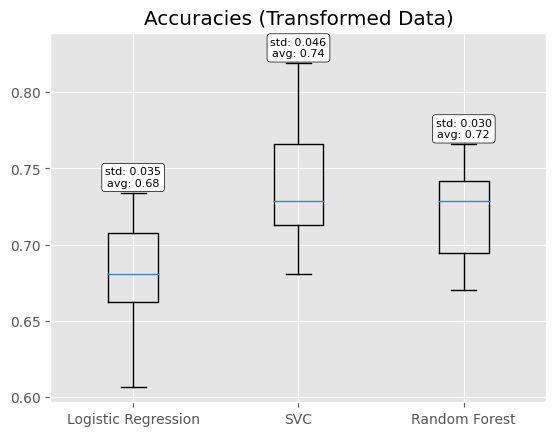

In [30]:
green_diamond = dict(markerfacecolor='g', marker='D')

acc_data = [[transformed_log_reg[k]['accuracy'] for k in transformed_log_reg.keys()],
 [transformed_svc[k]['accuracy'] for k in transformed_svc.keys()],
 [transformed_rf[k]['accuracy'] for k in transformed_rf.keys()]]
fig, ax = plt.subplots()
ax.set_title('Accuracies (Transformed Data)')
ax.boxplot(acc_data, flierprops=green_diamond)
ax.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])


ax.set_ylim([min(np.concatenate(acc_data))-0.01,
             max(np.concatenate(acc_data))+0.02])


for i, model_acc in enumerate(acc_data):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax.text(i + 1, max(model_acc)+0.01, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

_______

Performances on raw sequences

In [31]:
# get models performances on raw data
rf = k_train_test_splits(k=10, 
                        perform_model='random_forest',
                        scattering_net=False)
svc = k_train_test_splits(k=10, 
                        perform_model='SVC',
                        scattering_net=False)
logreg = k_train_test_splits(k=10, 
                        perform_model='log_reg',
                        scattering_net=False)

In [32]:
logreg

{95: {'confusion_matrix': array([[25,  2,  9],
         [ 6, 17,  5],
         [ 7, 13, 10]]),
  'accuracy': 0.5531914893617021,
  'precision': 0.5431830907054872,
  'recall': 0.5531914893617021,
  'F1': 0.5457670436393841,
  'precision_per_class': array([0.65789474, 0.53125   , 0.41666667]),
  'recall_per_class': array([0.69444444, 0.60714286, 0.33333333]),
  'f1_score_per_class': array([0.67567568, 0.56666667, 0.37037037])},
 68: {'confusion_matrix': array([[31,  7,  1],
         [ 2, 15,  4],
         [ 8, 14, 12]]),
  'accuracy': 0.6170212765957447,
  'precision': 0.6621043072132848,
  'recall': 0.6170212765957447,
  'F1': 0.6093365061590145,
  'precision_per_class': array([0.75609756, 0.41666667, 0.70588235]),
  'recall_per_class': array([0.79487179, 0.71428571, 0.35294118]),
  'f1_score_per_class': array([0.775     , 0.52631579, 0.47058824])},
 98: {'confusion_matrix': array([[29,  5,  7],
         [ 5,  7,  4],
         [ 8, 19, 10]]),
  'accuracy': 0.48936170212765956,
  'preci

In [33]:
svc

{23: {'confusion_matrix': array([[27,  3,  2],
         [ 4, 16,  1],
         [10,  9, 22]]),
  'accuracy': 0.6914893617021277,
  'precision': 0.7356720290607162,
  'recall': 0.6914893617021277,
  'F1': 0.6884984247269296,
  'precision_per_class': array([0.65853659, 0.57142857, 0.88      ]),
  'recall_per_class': array([0.84375   , 0.76190476, 0.53658537]),
  'f1_score_per_class': array([0.73972603, 0.65306122, 0.66666667])},
 42: {'confusion_matrix': array([[34,  1,  1],
         [ 4, 12,  5],
         [ 4,  9, 24]]),
  'accuracy': 0.7446808510638298,
  'precision': 0.7467808786957724,
  'recall': 0.7446808510638298,
  'F1': 0.7405639181249009,
  'precision_per_class': array([0.80952381, 0.54545455, 0.8       ]),
  'recall_per_class': array([0.94444444, 0.57142857, 0.64864865]),
  'f1_score_per_class': array([0.87179487, 0.55813953, 0.71641791])},
 18: {'confusion_matrix': array([[28,  7,  2],
         [ 8, 11,  7],
         [ 4, 10, 17]]),
  'accuracy': 0.5957446808510638,
  'precis

In [34]:
rf

{41: {'confusion_matrix': array([[34,  6,  1],
         [ 4,  9, 11],
         [ 4,  6, 19]]),
  'accuracy': 0.6595744680851063,
  'precision': 0.6515998300486976,
  'recall': 0.6595744680851063,
  'F1': 0.6548620011962744,
  'precision_per_class': array([0.80952381, 0.42857143, 0.61290323]),
  'recall_per_class': array([0.82926829, 0.375     , 0.65517241]),
  'f1_score_per_class': array([0.81927711, 0.4       , 0.63333333])},
 49: {'confusion_matrix': array([[37,  4,  3],
         [ 5, 13,  4],
         [ 1,  7, 20]]),
  'accuracy': 0.7446808510638298,
  'precision': 0.750190133230707,
  'recall': 0.7446808510638298,
  'F1': 0.7470607056239771,
  'precision_per_class': array([0.86046512, 0.54166667, 0.74074074]),
  'recall_per_class': array([0.84090909, 0.59090909, 0.71428571]),
  'f1_score_per_class': array([0.85057471, 0.56521739, 0.72727273])},
 55: {'confusion_matrix': array([[27,  7,  1],
         [ 7,  9,  5],
         [ 4,  7, 27]]),
  'accuracy': 0.6702127659574468,
  'precisi

In [35]:
result_raw = {
    'Metric (on RAW data)': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Logistic Regression': metrics_summary_per_model(logreg),
    'SVC': metrics_summary_per_model(svc),
    'Random Forest': metrics_summary_per_model(rf)
    }

result_raw_df = pd.DataFrame(result_raw)

result_raw_df.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True), axis=1)

,Metric (on RAW data),Logistic Regression,SVC,Random Forest
0,Accuracy,0.526596,0.647872,0.684043
1,Precision,0.545603,0.677256,0.691208
2,Recall,0.526596,0.647872,0.684043
3,F1-Score,0.517651,0.646217,0.684441


In [36]:
pd.DataFrame({
    'Model (on RAW data)': ['┌', 'Log Reg', '∟', 
              '┌', 'SVC', '∟', 
              '┌', 'RF', '∟'],
    'Class': ['Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)',  'Non-Event (0)', 'SI (1)', 'SSC (2)'],

    'Precision': np.concatenate([get_avg_metric_per_class(logreg, metric='precision_per_class'),
                                get_avg_metric_per_class(svc, metric='precision_per_class'),
                                get_avg_metric_per_class(rf, metric='precision_per_class')]),

    'Recall':np.concatenate([get_avg_metric_per_class(logreg, metric='recall_per_class'),
                                get_avg_metric_per_class(svc, metric='recall_per_class'),
                                get_avg_metric_per_class(rf, metric='recall_per_class')]),

    'F1-Score':np.concatenate([get_avg_metric_per_class(logreg, metric='f1_score_per_class'),
                                get_avg_metric_per_class(svc, metric='f1_score_per_class'),
                                get_avg_metric_per_class(rf, metric='f1_score_per_class')])

 }).style.background_gradient(cmap = sns.light_palette("green", as_cmap=True), axis=0)

,Model (on RAW data),Class,Precision,Recall,F1-Score
0,┌,Non-Event (0),0.658505,0.706106,0.677443
1,Log Reg,SI (1),0.410871,0.568093,0.472733
2,∟,SSC (2),0.497410,0.298516,0.364285
3,┌,Non-Event (0),0.704445,0.836843,0.760419
4,SVC,SI (1),0.454912,0.536644,0.481527
5,∟,SSC (2),0.776384,0.549470,0.640126
6,┌,Non-Event (0),0.781019,0.812305,0.795170
7,RF,SI (1),0.467225,0.517098,0.487757
8,∟,SSC (2),0.723715,0.648620,0.682103


In [37]:
pd.DataFrame({
    'Model': ['Log Reg Non-Event (0)', 'Log Reg SI (1)', 'Log Reg SSC (2)', 
              'SVC Non-Event (0)', 'SVC SI (1)', 'SVC SSC (2)', 
              'RF Non-Event (0)', 'RF SI (1)', 'RF SSC (2)'],

    'Precision': np.concatenate([get_avg_metric_per_class(logreg, metric='precision_per_class'),
                                get_avg_metric_per_class(svc, metric='precision_per_class'),
                                get_avg_metric_per_class(rf, metric='precision_per_class')]),

    'Recall':np.concatenate([get_avg_metric_per_class(logreg, metric='recall_per_class'),
                                get_avg_metric_per_class(svc, metric='recall_per_class'),
                                get_avg_metric_per_class(rf, metric='recall_per_class')]),

    'F1-Score':np.concatenate([get_avg_metric_per_class(logreg, metric='f1_score_per_class'),
                                get_avg_metric_per_class(svc, metric='f1_score_per_class'),
                                get_avg_metric_per_class(rf, metric='f1_score_per_class')])

 }).set_index('Model').T.style.background_gradient(cmap = sns.light_palette("green", as_cmap=True))

Model,Log Reg Non-Event (0),Log Reg SI (1),Log Reg SSC (2),SVC Non-Event (0),SVC SI (1),SVC SSC (2),RF Non-Event (0),RF SI (1),RF SSC (2)
Precision,0.658505,0.410871,0.497410,0.704445,0.454912,0.776384,0.781019,0.467225,0.723715
Recall,0.706106,0.568093,0.298516,0.836843,0.536644,0.549470,0.812305,0.517098,0.648620
F1-Score,0.677443,0.472733,0.364285,0.760419,0.481527,0.640126,0.795170,0.487757,0.682103


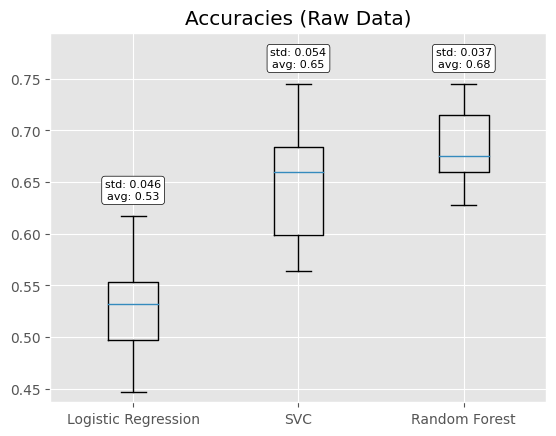

In [38]:
green_diamond = dict(markerfacecolor='g', marker='D')

acc_data = [[logreg[k]['accuracy'] for k in logreg.keys()],
            [svc[k]['accuracy'] for k in svc.keys()],
            [rf[k]['accuracy'] for k in rf.keys()]]
fig, ax = plt.subplots()
ax.set_title('Accuracies (Raw Data)')
ax.boxplot(acc_data, flierprops=green_diamond)
ax.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])


ax.set_ylim([min(np.concatenate(acc_data))-0.01,
             max(np.concatenate(acc_data))+0.05])


for i, model_acc in enumerate(acc_data):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax.text(i + 1, max(model_acc)+0.025, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.show()

____

Compare raw and transformed performances over 10 different train/test splits

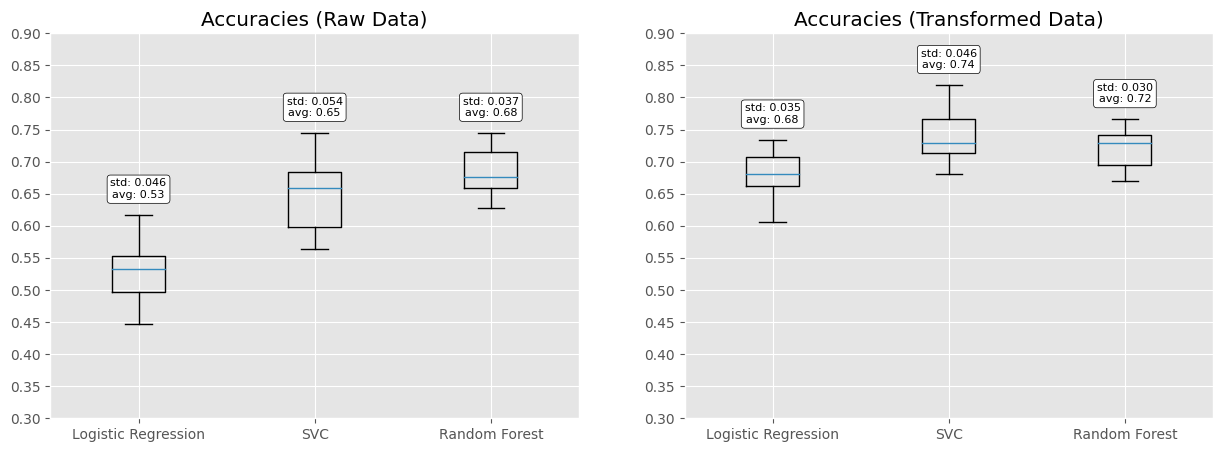

In [39]:
green_diamond = dict(markerfacecolor='g', marker='D')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

# RAW DATA ACCURACIES

acc_data_raw = [[logreg[k]['accuracy'] for k in logreg.keys()],
            [svc[k]['accuracy'] for k in svc.keys()],
            [rf[k]['accuracy'] for k in rf.keys()]] 

ax1.set_title('Accuracies (Raw Data)')
ax1.boxplot(acc_data_raw, flierprops=green_diamond)
ax1.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])

ax1.set_ylim([min(np.concatenate(acc_data_raw))-0.01,
             max(np.concatenate(acc_data_raw))+0.05])


for i, model_acc in enumerate(acc_data_raw):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax1.text(i + 1, max(model_acc)+0.04, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    
# TRANSFORMED DATA

acc_data_transf = [[transformed_log_reg[k]['accuracy'] for k in transformed_log_reg.keys()],
                    [transformed_svc[k]['accuracy'] for k in transformed_svc.keys()],
                    [transformed_rf[k]['accuracy'] for k in transformed_rf.keys()]]

ax2.set_title('Accuracies (Transformed Data)')
ax2.boxplot(acc_data_transf, flierprops=green_diamond)
ax2.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])


ax2.set_ylim([min(np.concatenate(acc_data_transf))-0.01,
             max(np.concatenate(acc_data_transf))+0.02])


for i, model_acc in enumerate(acc_data_transf):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax2.text(i + 1, max(model_acc)+0.04, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


# FIX: PUT SAME SCALE
y_ticks = np.arange(0.3, 0.9, 0.05)
ax1.set_yticks(y_ticks)
ax2.set_yticks(y_ticks)

plt.show()

In [40]:
print(f'Avg. accuracy on raw data across the models: {np.mean([np.mean(acc) for acc in acc_data_raw])}\nAvg. accuracy on transformed data across the models: {np.mean([np.mean(acc) for acc in acc_data_transf])}')

Avg. accuracy on raw data across the models: 0.6195035460992908
Avg. accuracy on transformed data across the models: 0.7131205673758866


______

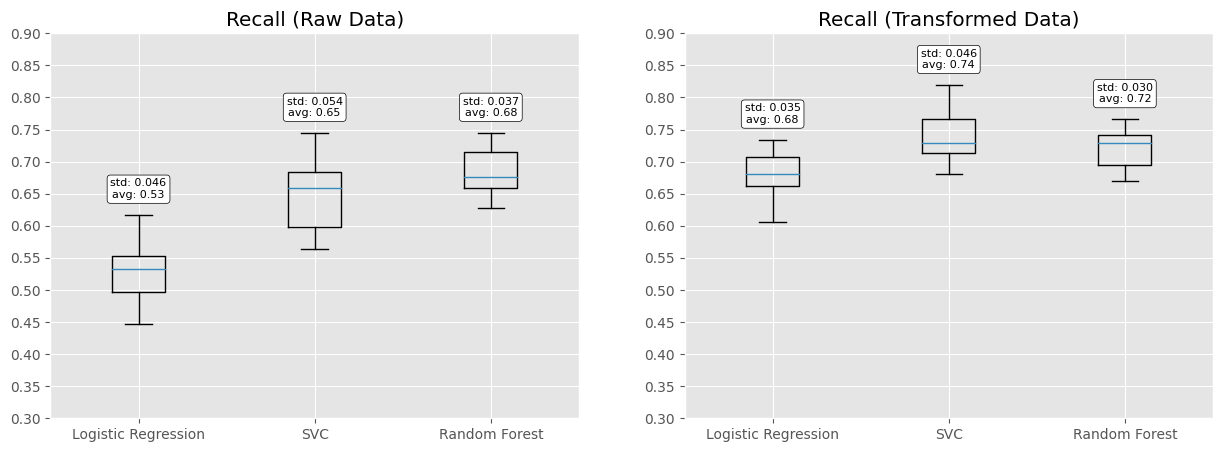

In [43]:
# EVALUATE DIFFERENT METRICS ACROSS 10 TRAIN-TEST SPLITS
metric = 'recall'


# PLOT
green_diamond = dict(markerfacecolor='g', marker='D')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

# RAW DATA 

acc_data_raw = [[logreg[k][metric] for k in logreg.keys()],
            [svc[k][metric] for k in svc.keys()],
            [rf[k][metric] for k in rf.keys()]] 

ax1.set_title(metric.capitalize()+' (Raw Data)')
ax1.boxplot(acc_data_raw, flierprops=green_diamond)
ax1.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])

ax1.set_ylim([min(np.concatenate(acc_data_raw))-0.01,
             max(np.concatenate(acc_data_raw))+0.05])


for i, model_acc in enumerate(acc_data_raw):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax1.text(i + 1, max(model_acc)+0.04, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    
# TRANSFORMED DATA

acc_data_transf = [[transformed_log_reg[k][metric] for k in transformed_log_reg.keys()],
                    [transformed_svc[k][metric] for k in transformed_svc.keys()],
                    [transformed_rf[k][metric] for k in transformed_rf.keys()]]

ax2.set_title(metric.capitalize()+' (Transformed Data)')
ax2.boxplot(acc_data_transf, flierprops=green_diamond)
ax2.set_xticklabels(['Logistic Regression', 'SVC', 'Random Forest'])


ax2.set_ylim([min(np.concatenate(acc_data_transf))-0.01,
             max(np.concatenate(acc_data_transf))+0.02])


for i, model_acc in enumerate(acc_data_transf):
    std_dev = np.std(model_acc)
    avg = np.mean(model_acc)
    ax2.text(i + 1, max(model_acc)+0.04, 
            f'std: {std_dev:.3f}\navg: {avg:.2f}', 
            horizontalalignment='center', verticalalignment='center', color='black',
            fontsize = 8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))


# FIX: PUT SAME SCALE
y_ticks = np.arange(0.3, 0.9, 0.05)
ax1.set_yticks(y_ticks)
ax2.set_yticks(y_ticks)

plt.show()